In [1]:
%load_ext nb_black

ImportError: cannot import name 'TypeGuard' from 'typing_extensions' (/home/shrank/.pyenv/versions/3.8.6/envs/ml/lib/python3.8/site-packages/typing_extensions.py)

In [2]:
import torch
import norse
import aedat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from norse.torch.module.conv import LConv2d
from tqdm.notebook import tqdm
import tonic
import tonic.transforms as transforms
from norse.torch.module.lif import LIF
from typing import NamedTuple
from norse.torch import LIFParameters, LIFState

In [3]:
transform = tonic.transforms.Compose(
    [
        transforms.Downsample(time_factor=1e-4, spatial_factor=0.25),
        transforms.ToFrame(n_time_bins=120, merge_polarities=True)
        # tonic.transforms.ToSparseTensor(merge_polarities=True),
    ]
)

download = False
trainset = tonic.datasets.DVSGesture(
    save_to="../data", transform=transform, download=download, train=True
)
testset = tonic.datasets.DVSGesture(
    save_to="../data", download=download, transform=transform, train=False
)

In [4]:
len(trainset)

1077

In [5]:
events = trainset[0][0]
print(f"events shape: {events.shape}")

events shape: (120, 1, 32, 32)


In [6]:
no_classes = len(trainset.classes)
print(f"number of classes: {no_classes}")
trainset.classes

number of classes: 11


['hand_clapping',
 'right_hand_wave',
 'left_hand_wave',
 'right_arm_clockwise',
 'right_arm_counter_clockwise',
 'left_arm_clockwise',
 'left_arm_counter_clockwise',
 'arm_roll',
 'air_drums',
 'air_guitar',
 'other_gestures']

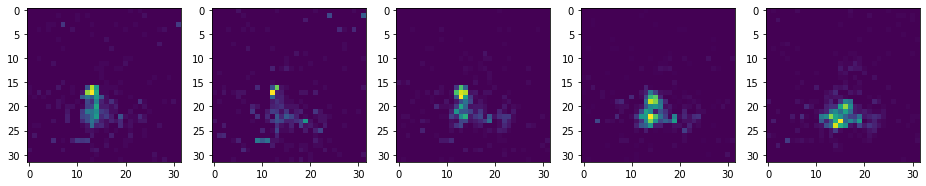

In [7]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 12))
columns = 5
rows = 1
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(events[i, 0])
plt.show()

In [8]:
train_labels = [x[1] for x in trainset]

In [9]:
x_train = [x[0] for x in trainset]

In [10]:
x_train_re = [x.reshape((120, 32, 32, 1)) for x in x_train]

In [13]:
train_labels = tf.keras.utils.to_categorical(train_labels, no_classes)

In [14]:
train_labels = train_labels.reshape((1077, 11, 1))

In [15]:
train_labels.shape

(1077, 11, 1)

In [16]:
x_train_re[0].shape

(120, 32, 32, 1)

In [17]:
np.array(x_train_re).shape

(1077, 120, 32, 32, 1)

In [18]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

In [19]:
model = models.Sequential()
model.add(layers.Conv3D(32, (3, 3, 3), activation="relu", input_shape=(120, 32, 32, 1)))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation="relu"))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(120))
model.add(layers.Dense(60))
model.add(layers.Dense(11))

2021-10-10 12:17:15.521754: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (100)
2021-10-10 12:17:15.521790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-J77RGTI): /proc/driver/nvidia/version does not exist
2021-10-10 12:17:15.522198: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [21]:
x = np.array(x_train_re)

In [22]:
x.shape

(1077, 120, 32, 32, 1)

In [29]:
train_labels = train_labels.reshape((1077, 11))
train_labels.shape

(1077, 11)

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((x, train_labels))

In [32]:
dataset

<TensorSliceDataset shapes: ((120, 32, 32, 1), (11,)), types: (tf.uint16, tf.float32)>

In [34]:
history = model.fit(
    dataset.batch(8),
    epochs=5,
    batch_size=8,
)

Epoch 1/5


2021-10-10 12:20:53.519940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


135/135 [==============================] - 97s 715ms/step - loss: 4.3883 - accuracy: 0.3398
Epoch 2/5
135/135 [==============================] - 97s 715ms/step - loss: 1.8710 - accuracy: 0.4513
Epoch 3/5
135/135 [==============================] - 97s 720ms/step - loss: 1.3022 - accuracy: 0.6082
Epoch 4/5
135/135 [==============================] - 96s 714ms/step - loss: 0.8035 - accuracy: 0.7809
Epoch 5/5
135/135 [==============================] - 97s 715ms/step - loss: 0.5220 - accuracy: 0.8319


In [35]:
test_labels = [x[1] for x in testset]
test_labels = tf.keras.utils.to_categorical(test_labels, no_classes)
x_test = [x[0] for x in testset]
x_test = [x.reshape((120, 32, 32, 1)) for x in x_test]
x_test = np.array(x_test)

In [36]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))

In [38]:
test_dataset

<TensorSliceDataset shapes: ((120, 32, 32, 1), (11,)), types: (tf.uint16, tf.float32)>

In [39]:
model.evaluate(test_dataset.batch(8))

33/33 [==============================] - 2s 65ms/step - loss: 1.3747 - accuracy: 0.7348


[1.3746509552001953, 0.7348484992980957]

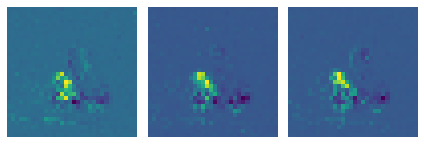

<IPython.core.display.Javascript object>

In [6]:
tonic.utils.plot_event_grid(events, trainset.ordering)

In [8]:
events[0]

array([1.225e+01, 2.050e+01, 0.000e+00, 2.800e-03])

<IPython.core.display.Javascript object>

In [6]:
dense_transform = tonic.transforms.Compose(
    [
        tonic.transforms.ToSparseTensor(merge_polarities=True),
    ]
)

<IPython.core.display.Javascript object>

In [6]:
# reduce this number if you run out of GPU memory
BATCH_SIZE = 16

# add sparse transform to trainset, previously omitted because we wanted to look at raw events
# trainset.transform = dense_transform
# testset.transform = dense_transform

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, collate_fn=tonic.utils.pad_tensors, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, collate_fn=tonic.utils.pad_tensors, shuffle=False
)

<IPython.core.display.Javascript object>

In [8]:
inp, tar = trainset[0]
inp.shape

torch.Size([505, 1, 32, 32])

<IPython.core.display.Javascript object>

In [9]:
neuron = LIF()
voltage_trace, _ = neuron(inp)

<IPython.core.display.Javascript object>

In [10]:
neuron

LIF(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.)), dt=0.001)

<IPython.core.display.Javascript object>

In [11]:
voltage_trace.shape

torch.Size([505, 1, 32, 32])

<IPython.core.display.Javascript object>

In [12]:
v_t = voltage_trace.detach().to_dense()
v_t = torch.reshape(v_t, (505, 32, 32))
v_t.shape

torch.Size([505, 32, 32])

<IPython.core.display.Javascript object>

In [13]:
v_t.shape

torch.Size([505, 32, 32])

<IPython.core.display.Javascript object>

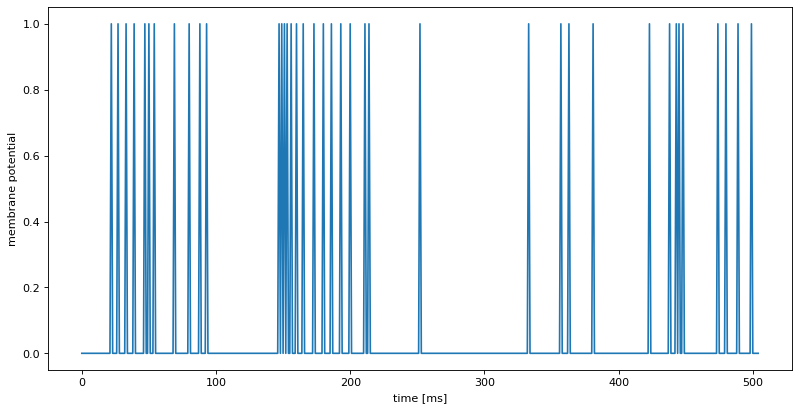

<IPython.core.display.Javascript object>

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=80)
plt.xlabel("time [ms]")
plt.ylabel("membrane potential")
plt.plot(v_t[:, 17, 17])

In [19]:
class SNNState(NamedTuple):
    lif0: LIFState

<IPython.core.display.Javascript object>

In [20]:
class SimpleSNN(torch.nn.Module):
    def __init__(
        self,
    ):
        super(SimpleSNN, self).__init__()
        self.l1 = LIF()

    def forward(self, x):
        voltage_trace, _ = self.l1(x)

        return voltage_trace

<IPython.core.display.Javascript object>

In [46]:
traces = []
targets = []

idx = 0

snn = SimpleSNN()


for i, t in tqdm(trainset):
    if idx == 100:
        break

    trace = snn(i)

    traces.append(trace)
    targets.append(t)

    idx += 1

  0%|          | 0/1077 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [47]:
traces[0].shape

torch.Size([505, 1, 32, 32])

<IPython.core.display.Javascript object>

In [48]:
max_shape = max([x.shape[0] for x in traces])

<IPython.core.display.Javascript object>

In [49]:
max_shape

1217

<IPython.core.display.Javascript object>

In [25]:
voltage_traces[0].shape

torch.Size([16, 969, 1, 32, 32])

<IPython.core.display.Javascript object>

In [50]:
1217 - 505

712

<IPython.core.display.Javascript object>

In [58]:
torch.nn.functional.pad(traces[0], (505, 1217), mode="constant", value=0).shape

NotImplementedError: Could not run 'aten::fill_.Scalar' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::fill_.Scalar' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Named, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, UNKNOWN_TENSOR_TYPE_ID, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:16286 [kernel]
CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA.cpp:20674 [kernel]
Meta: registered at /pytorch/build/aten/src/ATen/RegisterMeta.cpp:9460 [kernel]
QuantizedCPU: registered at /pytorch/build/aten/src/ATen/RegisterQuantizedCPU.cpp:1025 [kernel]
QuantizedCUDA: registered at /pytorch/build/aten/src/ATen/RegisterQuantizedCUDA.cpp:269 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: fallthrough registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
ADInplaceOrView: registered at /pytorch/torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:2322 [kernel]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradMLC: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_3.cpp:10820 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_3.cpp:10078 [kernel]
Autocast: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:255 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/BatchingRegistrations.cpp:1023 [kernel]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


<IPython.core.display.Javascript object>

In [62]:
len(trainset.classes)

11

<IPython.core.display.Javascript object>

In [85]:
class Model(torch.nn.Module):
    def __init__(self, snn):
        super(Model, self).__init__()
        self.snn = snn
        self.flatten = torch.nn.Flatten(0, -1)
        self.linear = torch.nn.Linear(517120, 11)
        self.softmax = torch.nn.Softmax(0)

    def forward(self, x):
        voltage_trace = self.snn(x)
        flatten = self.flatten(x)
        linear = self.linear(flatten)
        return self.softmax(linear)

<IPython.core.display.Javascript object>

In [86]:
LR = 0.002
SNN = SimpleSNN()
model = Model(SNN)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SimpleSNN(
    (l1): LIF(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.)), dt=0.001)
  )
  (flatten): Flatten(start_dim=0, end_dim=-1)
  (linear): Linear(in_features=517120, out_features=11, bias=True)
  (softmax): Softmax(dim=0)
)

<IPython.core.display.Javascript object>

In [93]:
lowest_shape = float("inf")
for (data, target) in tqdm(train_loader):
    s = data.shape[1]
    if s < lowest_shape:
        lowest_shape = s

  0%|          | 0/68 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [94]:
lowest_shape

742

<IPython.core.display.Javascript object>

In [88]:
from tqdm.notebook import tqdm, trange

EPOCHS = 5  # Increase this number for better performance


def train(model, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to_dense(), torch.LongTensor(target)
        print(data.shape)
        print(target.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to_dense(), torch.LongTensor(target)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy


training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(
        model, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

torch.Size([16, 812, 1, 32, 32])
torch.Size([16, 812, 1, 32, 32])
torch.Size([16])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x13303808 and 517120x11)

<IPython.core.display.Javascript object>

In [ ]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self,
        input_features,
        hidden_features,
        output_features,
        tau_syn_inv,
        tau_mem_inv,
        record=False,
        dt=1e-6,
    ):
        super(SNN, self).__init__()

        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(
                alpha=100,
                v_th=torch.tensor(1),
                tau_syn_inv=tau_syn_inv,
                tau_mem_inv=tau_mem_inv,
            ),
            dt=dt,
        )

        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

In [ ]:
example_snn = SNN(
    np.product(input_features),
    100,
    len(trainset.classes),
    tau_syn_inv=torch.tensor(1 / 1e-4),
    tau_mem_inv=torch.tensor(1 / 1e-4),
    record=True,
    dt=1e-6,
)

example_events, target = trainset[10]

example_input = example_events.to_dense().unsqueeze(
    1
)  # the unsqueeze just signifies a batch size of 1
example_input.shape

In [ ]:
example_readout_voltages = example_snn(example_input)

In [ ]:
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [us]")
plt.show()

In [ ]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

In [ ]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [ ]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y


class Model(torch.nn.Module):
    def __init__(self, snn, decoder):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [ ]:
LR = 0.002
INPUT_FEATURES = np.product(input_features)
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = len(trainset.classes)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
        tau_syn_inv=torch.tensor(1 / 1e-4),
        tau_mem_inv=torch.tensor(1 / 1e-4),
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

In [ ]:
from tqdm.notebook import tqdm, trange

EPOCHS = 5  # Increase this number for better performance


def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device).to_dense().permute(
            [1, 0, 2, 3, 4]
        ), torch.LongTensor(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [ ]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).to_dense().permute(
                [1, 0, 2, 3, 4]
            ), torch.LongTensor(target).to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [ ]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

In [ ]:
trained_snn = model.cpu()
trained_readout_voltages = trained_snn(example_input)
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()